In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
## Defining Class for SMO Model

class SMOModel:
    
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data 
        self.y = y               # classes
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier 
        self.b = b               # bias
        self.errors = errors     # error
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

In [74]:
## Defining Kernel Functions

def linear_kernel(x, y):
    
    return x @ y.T


def gaussian_kernel(x, y, sigma=1):
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

In [75]:
# Objective function to optimize
## Dual form of the objective function and decision function

def objective_function(alphas, target, kernel, X_train):
    
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))

# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    result = (alphas * target) @ kernel(X_train, x_test) + b
    return result

In [76]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    else:
        return 0, model
    
    value = abs(a2 - alph2)
    
    if value < 10**-5 :
        return 0, model
    
     # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
        
    # Update threshold b 
    b1 = model.b - (E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12) 
    b2 = model.b - (E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22)
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [77]:
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [78]:
def train(model):
    passes = 0
    max_passes = 10
    
    while(passes < max_passes):
        
        numChanged_alphas = 0
    
        for i in range(m):
            examine_result, model = examine_example(i, model)
            numChanged_alphas += examine_result
    
        if numChanged_alphas == 0 :
            passes = passes + 1
        
        else :
            passes=0
        
    return model

In [79]:
import pandas as pd

In [80]:
d = pd.read_excel('smodata.xlsx')

In [81]:
d.head(10)

,x1,x2,y
0,0.601266,0.165091,-1
1,0.871725,0.527361,1
2,0.372548,0.446609,-1
3,0.013577,0.051358,-1
4,0.583032,0.710619,1
5,0.908480,0.175272,1
6,0.399964,0.473995,-1
7,0.832537,0.598048,1
8,0.004816,0.984457,-1
9,0.749908,0.045424,-1


In [82]:
X_train = d.iloc[:,0:2]
y = d.iloc[:,2]

In [83]:
X_train.head()

,x1,x2
0,0.601266,0.165091
1,0.871725,0.527361
2,0.372548,0.446609
3,0.013577,0.051358
4,0.583032,0.710619


In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

In [87]:
# Set model parameters and initial values
C = .1
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # numerical tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

In [88]:
np.random.seed(0)
output = train(model)

In [89]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)
        
        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')
        
        return grid, ax

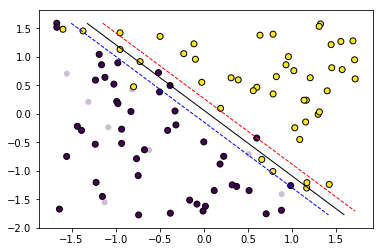

In [90]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [91]:
output.alphas.sum()

9.2

In [92]:
## Using Gaussian Kernel

C = .1
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # numerical tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

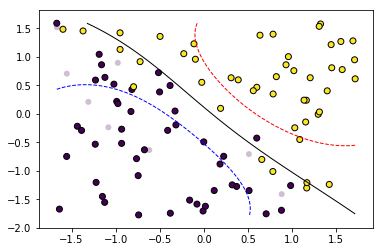

In [93]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [94]:
output.alphas.sum()

9.199999999999998